![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [2]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [3]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [4]:
engine = create_engine('sqlite:///:memory:')

In [5]:
produtos.to_sql('produtos', engine, index = False)

205

In [6]:
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index = False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [7]:
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


**Nessa aula, você aprendeu a:**
- Listar as ferramentas úteis para integrar o Python e SQL;
- Compreender os dados e o tipo de informação fornecida neles;
- Identificar SQL e suas cláusulas;
- Diferenciar o SQLite de outros tipos de SGBDs; e
- Inserir tabelas no banco com to_sql.

# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [8]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [9]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall()
pd.DataFrame(dados,  columns =consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [10]:
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados,  columns =consulta.keys())

In [11]:
query = '''SELECT CONDICAO, COUNT(*) as 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


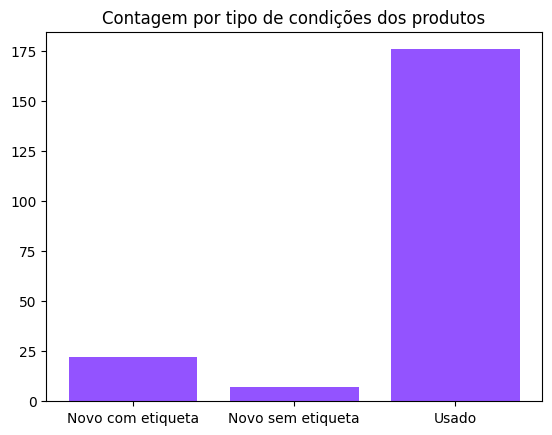

In [12]:
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color = '#9353ff')
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [13]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [14]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [15]:
  query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
  FROM ITENS_PEDIDOS, PRODUTOS
  WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
  GROUP BY PRODUTOS.PRODUTO
  ORDER BY Quantidade ASC'''

  prod_quant = sql_df(query)
  prod_quant

,produto,Quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


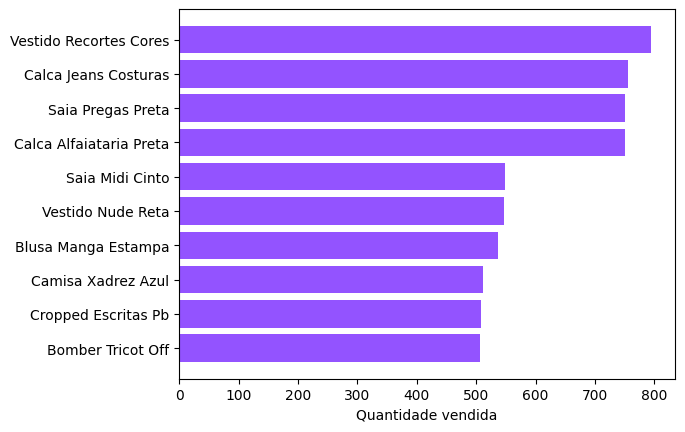

In [16]:
plt.barh(prod_quant['produto'][-10:],prod_quant['Quantidade'][-10:], color = '#9353FF')
plt.xlabel('Quantidade vendida')

plt.show()

**Nessa aula, você aprendeu a:**
- Selecionar dados específicos dentro de uma tabela;
- Aplicar funções de agregação em uma consulta;
- Construir consultas que relacionam duas tabelas; e
- Criar visualizações úteis para a análise.

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [17]:
sql_df('SELECT * FROM PEDIDOS')

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575
...,...,...,...,...,...
24522,63716,64127,1,2021-03-09,2360
24523,63999,37384,2,2021-03-09,2800
24524,64594,100932,1,2021-03-10,19500
24525,64811,3820,3,2021-03-10,417


In [18]:
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [19]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR AS 'Nome vendedor', AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''
sql_df(query)

,Nome vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


In [20]:
#fazendo a mesma coisa utilizando Pandas
df_filtrado = pedidos[pedidos['data_compra'].str.startswith('2020')]
df_mesclado = df_filtrado.merge(vendedores, on='vendedor_id')
df_agrupado = df_mesclado.groupby('nome_vendedor')['total'].mean().reset_index()
df_filtro_data = df_agrupado.sort_values('total', ascending=False).reset_index(drop=True)
df_filtro_data.columns = ['nome_vendedor', 'Valor médio por vendas']
df_filtro_data


,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


**Nessa aula, você aprendeu a:**
- Identificar os tipos de dados que estão sendo trabalhados;
- Coletar informações específicas de uma data;
- Filtrar dados a partir de um período do tempo; e
- Listar as funções de agregação do SQLite.

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [21]:
query = '''SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;
'''

sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [35]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC;
'''
sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157


In [47]:
#fazendo da mesma forma utilizando o Pandas
df_unido = pedidos.merge(vendedores, on='vendedor_id').merge(itens_pedidos, on='pedido_id')
df_filtrado = df_unido.query("Estado == 'BR-SP'")
df_vendedores_sp = df_filtrado.groupby('nome_vendedor').size().reset_index(name='quantidade_vendas')
df_vendedores_sp = df_vendedores_sp.sort_values('quantidade_vendas', ascending=False)
df_vendedores_sp


,nome_vendedor,quantidade_vendas
1,Daniel Siqueira,190
4,Paulo Calanca,182
3,Nadia Oliveira,181
0,Ana Duarte,180
2,Millena Pereira,157


**Nessa aula, você aprendeu a:**
- Verificar a necessidade de uma ação na empresa;
- Filtrar dados por estado;
- Unir tabelas com JOIN;
- Auxiliar na tomada de decisão com base em consulta e análise dados; e
- Definir outras formas de conexões do Python com diferentes SGBDs.

# Desafios

## 1:
Esse primeiro desafio vai ser constituído de duas análises, a primeira tem por objetivo calcular a receita total obtida com a venda de itens. Na tabela itens_pedidos, o valor total dos itens representa o cálculo da quantidade pelo valor unitário e pode ser considerado como a receita da venda.

In [22]:
query = 'SELECT * FROM ITENS_PEDIDOS'

In [23]:
sql_df(query)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0
...,...,...,...,...,...,...,...,...
24522,25051,64127,63716,4,590,2360,BR-PE,472.0
24523,25052,37384,63999,4,700,2800,BR-RO,560.0
24524,25053,100932,64594,5,3900,19500,BR-RO,3900.0
24525,25054,3820,64811,3,139,417,BR-MA,83.4


In [24]:
df_pedidos = sql_df("SELECT VALOR_TOTAL FROM ITENS_PEDIDOS")
receita = df_pedidos['valor_total'].sum()
receita

45803930

## 2:
Já a segunda análise visa identificar quais as 15 marcas que foram as mais pedidas por quantidades de venda. Busque mostrar essa lista em uma visualização, além de expor o nome das marcas.

In [25]:
itens_mais_vendidos = sql_df('''SELECT PRODUTOS.MARCA, COUNT(*) AS Pedidos
  FROM PRODUTOS, ITENS_PEDIDOS
  WHERE PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
  GROUP BY PRODUTOS.MARCA
  ORDER BY Pedidos DESC''')


In [26]:
itens_mais_vendidos.head(15)

,marca,Pedidos
0,Zara,2721
1,Mixed,1673
2,Animale,1128
3,Le Lis Blanc,715
4,Banana Republic,584
5,Farm,506
6,H&m,446
7,Sacada,381
8,Shoulder,372
9,Dress&co,360


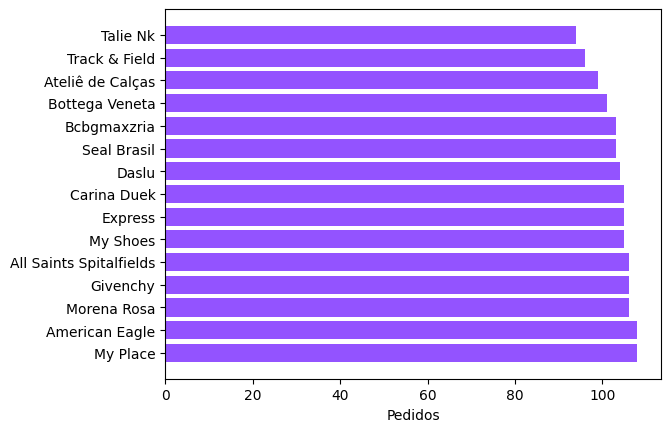

In [27]:
plt.barh(itens_mais_vendidos['marca'][-15:],itens_mais_vendidos['Pedidos'][-15:], color = '#9353FF')
plt.xlabel('Pedidos')
plt.show;

## 3:
Vamos aos desafios dessa aula, o primeiro é exibir os 10 produtos mais vendidos durante o ano de 2019, que podem ser representados em uma tabela.

In [28]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT(PEDIDOS.PEDIDO_ID) AS TOTAL_PEDIDOS
  FROM PEDIDOS, PRODUTOS
  WHERE strftime('%Y', data_compra) = '2019' AND PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
  GROUP BY PRODUTOS.PRODUTO
  ORDER BY TOTAL_PEDIDOS DESC
  LIMIT 10;
'''

sql_df(query)

,produto,TOTAL_PEDIDOS
0,Vestido Recortes Cores,85
1,Calca Jeans Costuras,81
2,Saia Pregas Preta,73
3,Calca Alfaiataria Preta,66
4,Camisa Xadrez Azul,60
5,Bomber Tricot Off,56
6,Shorts Bordado Branco,55
7,Blusa Manga Estampa,54
8,Saia Midi Cinto,53
9,Saia Evase Cinza,53


## 4:
Já o segundo será publicar a distribuição através dos meses da receita obtida em vendas no ano de 2021. Busque mostrar essa distribuição colocando o mês e sua receita correspondente na visualização.

In [29]:
query = '''SELECT strftime('%m', data_compra) AS mes, SUM(total) AS receita
FROM pedidos
WHERE strftime('%Y', data_compra) = '2021'
GROUP BY mes;
'''
sql_df(query)


,mes,receita
0,01,2097109
1,02,1140729
2,03,51525


In [51]:
itens_pedidos.head()

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [50]:
pedidos.head()

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [49]:
itens_pedidos.head()

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [53]:
produtos

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248,Usado
...,...,...,...,...,...,...
200,14074,Camisa Amarela Laco,450,Carol Bassi,309858,Usado
201,33349,Vestido Listras Malha,270,Calvin Klein,307118,Usado
202,22568,Casaqueto Estampa Geometrica,245,Zara,244931,Usado
203,40508,Regata Bicolor Alcinha,245,Express,247166,Usado


## 5:
A primeira informação é listar as marcas vendidas em São Paulo por quantidade de pedidos, que podem ser representadas em uma tabela.

In [60]:
query = '''SELECT PRODUTOS.MARCA, COUNT(ITENS_PEDIDOS.PRODUTO_ID) AS Pedidos
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PRODUTOS.MARCA
ORDER BY Pedidos DESC;
'''

sql_df(query)

,marca,Pedidos
0,Zara,100
1,Mixed,58
2,Animale,44
3,Le Lis Blanc,26
4,Banana Republic,18
...,...,...
111,Topshop,1
112,Morena Rosa,1
113,Erre Erre,1
114,Bobô,1


## 6:
Já a segunda informação é publicar os produtos que são mais vendidos na época de Natal no Brasil todo. Essa última informação é aplicada a todos os estados porque somente o estado de São Paulo pode não trazer uma quantidade relevante de informações.

In [84]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT(ITENS_PEDIDOS.PRODUTO_ID) AS 'quantidade_vendas'
FROM PRODUTOS
JOIN ITENS_PEDIDOS ON PRODUTOS.PRODUTO_ID = ITENS_PEDIDOS.PRODUTO_ID
JOIN PEDIDOS ON PEDIDOS.PEDIDO_ID = ITENS_PEDIDOS.PEDIDO_ID
WHERE strftime('%m', DATA_COMPRA) = '12'
GROUP BY PRODUTOS.PRODUTO
ORDER BY quantidade_vendas DESC;
'''

RESULTADO = sql_df(query)
RESULTADO

,produto,quantidade_vendas
0,Vestido Recortes Cores,30
1,Vestido Preto Franzido,26
2,Calca Jeans Costuras,26
3,Calca Alfaiataria Preta,26
4,Camisa Xadrez Azul,25
...,...,...
196,Sneaker Monograma Bege,6
197,Casaqueto Estampa Geometrica,6
198,Regata Renda Branca,5
199,Body Estampa Coracoes,5
